# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..','..'))

from data_models.parameters import arl_path
results_dir = arl_path('test_results')

from matplotlib import pylab

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.polarisation import PolarisationFrame

from processing_components.visibility.base import create_visibility
from processing_components.skycomponent.operations import create_skycomponent
from processing_components.image.operations import show_image, export_image_to_fits, smooth_image
from processing_components.image.deconvolution import deconvolve_cube, restore_cube
from libs.image.iterators import  image_raster_iter
from processing_components.image.solvers import solve_image
from processing_components.visibility.iterators import vis_timeslice_iter
from processing_components.simulation.testing_support import create_named_configuration, create_low_test_beam, \
    create_low_test_image_from_gleam
from processing_components.imaging.imaging_functions import invert_function, predict_function
from processing_components.imaging.weighting import weight_visibility

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'


We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
config = 'core'
if config == 'full':
    b = 8e4
    cellsize = 0.00001
    npixel=10 * 2048
    padding = 1
    context = '2d'

else:
    b = 4e3
    cellsize = 0.001
    npixel=256
    padding = 2
    context='wstack'
    
low = create_named_configuration('LOWBD2', rmax=b)
    
oversampling = 32
frequency = numpy.linspace(0.99e8, 1.01e8, 3)
channel_bandwidth=numpy.array([1e6, 1e6, 1e6])
times = numpy.linspace(-3, +3, 15) * numpy.pi / 12.0
log.info('Observing times %s' % (times))

log.info("Observing frequencies %s Hz" % str(frequency))

log.info("Cellsize = %.6f radians" % (cellsize))

create_configuration_from_file: Maximum radius 4000.0 m includes 332 antennas/stations


Observing times [-0.78539816 -0.67319843 -0.56099869 -0.44879895 -0.33659921 -0.22439948
 -0.11219974  0.          0.11219974  0.22439948  0.33659921  0.44879895
  0.56099869  0.67319843  0.78539816]


Observing frequencies [9.90e+07 1.00e+08 1.01e+08] Hz


Cellsize = 0.001000 radians


In [5]:
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 2472570 rows, 0.258 GB


Plot the synthesized uv coverage, including for MFS

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


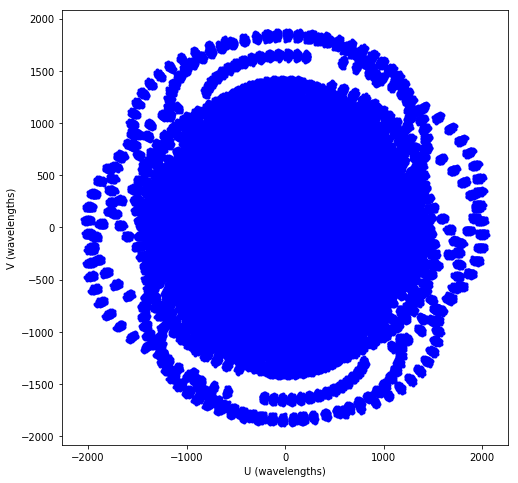

In [6]:
plt.clf()
plt.plot(vt.uvw[:,0],   vt.uvw[:,1], '.', color='b')
plt.plot(-vt.uvw[:,0], -vt.uvw[:,1], '.', color='b')
plt.xlabel("U (wavelengths)")
plt.ylabel("V (wavelengths)")
plt.show()

Make a test image

In [10]:
model = create_low_test_image_from_gleam(npixel=npixel, frequency=frequency,
                                         channel_bandwidth=channel_bandwidth,
                                         cellsize=cellsize,
                                         phasecentre=phasecentre, flux_limit=0.1,
                                         radius=0.2)
export_image_to_fits(model, '%s/imaging-low-model.fits' % (results_dir))


create_low_test_skycomponents_from_gleam: 1860 sources above flux limit 0.100


insert_skycomponent: Using insert method Nearest


Quality assessment:
	Origin: qa_image
	Context: create_low_test_image_from_gleam
	Data:
		shape: '(3, 1, 256, 256)'
		max: '24.805549621582028'
		min: '0.0'
		rms: '0.2088592508815346'
		sum: '2557.8883880664844'
		medianabs: '0.0'
		median: '0.0'



In [ ]:
beam=create_low_test_beam(model)
model.data*=beam.data
print("Model * beam has %.3f Jy" % (numpy.sum(model.data[0,0,:,:])))
cmodel = smooth_image(model)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()
export_image_to_fits(cmodel, '%s/imaging-low-cmodel.fits' % (results_dir))
beam = None
cmodel = None

In [ ]:
vt.data['vis'] *= 0.0
vt = predict_function(vt, model, context=context, kernel=kernel, padding=1)

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

From now on, we will work with MFS images

In [ ]:
from libs.imaging.base import create_image_from_visibility
model = create_image_from_visibility(vt, npixel=npixel, nchan=1, phasecentre=phasecentre, 
                                     cellsize=cellsize)

Weight the data

In [ ]:
vt, density, densitygrid = weight_visibility(vt, model)
plt.clf()
plt.semilogy(uvdist, density, '.')
plt.xlabel('uvdist')
plt.ylabel('Sample density')
plt.show()
density = None
densitygrid = None

Make the dirty image and point spread function

In [ ]:
dirty, sumwt = invert_function(vt, model, context=context, kernel=kernel, padding=1)
show_image(dirty)

psf, sumwt = invert_function(vt, model, dopsf=True, context=context, kernel=kernel, padding=1)


print("Max, min in dirty image = %.6f, %.6f, sumwt = %s" % (dirty.data.max(), dirty.data.min(), sumwt))
print("Max, min in PSF         = %.6f, %.6f, sumwt = %s" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging-low-dirty.fits' % (results_dir))
export_image_to_fits(psf, '%s/imaging-low-psf.fits' % (results_dir))

dirty = None

Do some major cycles

In [ ]:
model.data[...] = 0.0
vtres, comp, residual = solve_image(vt, model, niter=10000, fractional_threshold=0.1, 
                                    threshold=0.050, nmajor=5, gain=0.1, 
                                    algorithm='hogbom', padding=padding,
                                    context=context, kernel=kernel)

fig=show_image(comp)
fig=show_image(residual)

In [ ]:
clean = restore_cube(model=comp, psf=psf, residual=residual)
export_image_to_fits(clean, '%s/imaging-low-clean.fits' % (results_dir))
show_image(clean)

Predict the visibility of the model

In [ ]:
vtmodel = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_function(vtmodel, comp, context=context, kernel=kernel, timeslice=1.0)

Now we will plot the original visibility and the residual visibility.

In [ ]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.', color='b', label='Original')
plt.plot(uvdist, numpy.abs(vt.data['vis']-vtmodel.data['vis']), '.', color='r', 
         label='Residual')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()